In [0]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
from torch import optim
from torch import nn
from torch import distributions as dist
from enum import Enum

# boolean variable that indicates whether or not we have gpu...
use_cuda = torch.cuda.is_available()
print("Use GPU: {}".format(use_cuda))

# Default gaussian mixture parameters
PI = 0.5

SIGMA_1 = torch.tensor([math.exp(-0)])
SIGMA_2 = torch.tensor([math.exp(-6)])

# place tensor in GPU if use_cuda
if use_cuda:
  SIGMA_1 = SIGMA_1.cuda()
  SIGMA_2 = SIGMA_2.cuda()

# Default gaussian parameters
MU_PRIOR = 0
SIGMA_PRIOR = torch.tensor([math.exp(-0)])

# place tensor in GPU if use_cuda
if use_cuda:
    SIGMA_PRIOR = SIGMA_PRIOR.cuda()

# Initial weight hyperparameters
MU_WEIGHTS = (-0.03, 0.03)
RHO_WEIGHTS = (-8, -7)
MU_BIAS = (-0.03, 0.03)
RHO_BIAS = (-8, -7)

# Loss variance
SIGMA = torch.tensor([math.exp(-2)])

# place tensor in GPU if use_cuda
if use_cuda:
    SIGMA = SIGMA.cuda()

class PriorType(Enum):
  MIXTURE = 1
  GAUSSIAN = 2

class ActivationType(Enum):
  NONE = 0
  RELU = 1
  SOFTMAX = 2
  TANH = 3
  SIGMOID = 4

class TaskType(Enum):
  REGRESSION = 1
  CLASSIFICATION = 2

class GaussianMixture(object):

  def __init__(self, pi, sigma1, sigma2):
    self.pi = pi
    self.sigma1 = sigma1
    self.sigma2 = sigma2
    if use_cuda:
      self.sigma1 = self.sigma1.cuda()
      self.sigma2 = self.sigma2.cuda()
    print(self.sigma1)
    print(self.sigma2)

  # arguments of dist.Normal() should be tensors rather than scalars
  def log_prob(self, weights):
    new_weights = weights.view(-1)
    normal_density1 = dist.Normal(0,self.sigma1).log_prob(new_weights)
    exp_normal_density1 = torch.exp(normal_density1)
    exp_normal_density2 = torch.exp(
        dist.Normal(0.0, self.sigma2).log_prob(new_weights))
    nonzero = exp_normal_density2.nonzero()
    zero = (exp_normal_density2==0).nonzero()
    sum_log_prob = torch.sum(torch.log(self.pi * torch.take(exp_normal_density1,nonzero) \
                  + (1-self.pi)*torch.take(exp_normal_density2,nonzero))) \
                  + torch.sum(torch.take(normal_density1, zero)+np.log(self.pi))
    return sum_log_prob
  '''def log_prob(self, weights):
    normal_density1 = torch.exp(
        dist.Normal(0.0, self.sigma1).log_prob(weights))
    normal_density2 = torch.exp(
        dist.Normal(0.0, self.sigma2).log_prob(weights))
    sum_log_prob = torch.sum(torch.log(self.pi * normal_density1 + (1-self.pi)*normal_density2))
    return sum_log_prob'''

class BayesianLayer(nn.Module):

  def __init__(self,
               input_size,
               output_size,
               prior_type=PriorType.MIXTURE,
               prior_params={'pi' : PI, 'sigma1' : SIGMA_1, 'sigma2' : SIGMA_2},
               activation_type=ActivationType.NONE,
               initial_mu_weights=MU_WEIGHTS,
               initial_mu_bias=MU_BIAS,
               initial_rho_weights=RHO_WEIGHTS,
               initial_rho_bias=RHO_BIAS
              ):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.activation_type = activation_type

    # create torch variables
    if not use_cuda:
        self.mu_weights = nn.Parameter(torch.Tensor(output_size, input_size))
        self.rho_weights = nn.Parameter(torch.Tensor(output_size, input_size))
        self.mu_bias = nn.Parameter(torch.Tensor(output_size))
        self.rho_bias = nn.Parameter(torch.Tensor(output_size))
        self.normal_dist = dist.Normal(torch.Tensor([0]), torch.Tensor([1]))
    else:
        self.mu_weights = nn.Parameter(torch.Tensor(output_size, input_size).cuda())
        self.rho_weights = nn.Parameter(torch.Tensor(output_size, input_size).cuda())
        self.mu_bias = nn.Parameter(torch.Tensor(output_size).cuda())
        self.rho_bias = nn.Parameter(torch.Tensor(output_size).cuda())
        self.normal_dist = dist.Normal(torch.Tensor([0]).cuda(), torch.Tensor([1]).cuda())

    # initialize variables
    self.mu_weights.data.uniform_(*initial_mu_weights)
    self.rho_weights.data.uniform_(*initial_rho_weights)
    self.mu_bias.data.uniform_(*initial_mu_bias)
    self.rho_bias.data.uniform_(*initial_rho_bias)

    if prior_type == PriorType.MIXTURE:
      self.prior_weights = GaussianMixture(
          prior_params['pi'], prior_params['sigma1'], prior_params['sigma2'])
      self.prior_bias = GaussianMixture(
          prior_params['pi'], prior_params['sigma1'], prior_params['sigma2'])
    else:
      self.prior_weights = dist.Normal(prior_params['mean'],
                                       prior_params['sigma'])
      self.prior_bias = dist.Normal(prior_params['mean'],
                                    prior_params['sigma'])
    self.log_prior = 0
    self.log_posterior = 0

  def _compute_gaussian_sample(self, mu, rho):
    epsilon = self.normal_dist.sample(rho.size()).squeeze(-1)
    return mu + torch.log(1 + torch.exp(rho)) * epsilon

  def forward(self, input_data, sample=False, debug=False):
    if self.training or sample:
      weights = self._compute_gaussian_sample(self.mu_weights, self.rho_weights)
      bias = self._compute_gaussian_sample(self.mu_bias, self.rho_bias)
      if debug is True:
        pass
        # print("sampled weights:")
        # print(weights)
      self.log_prior = (self.prior_weights.log_prob(weights).sum() +
                        self.prior_bias.log_prob(bias).sum() )
      sigma_weights = torch.log(1 + torch.exp(self.rho_weights))
      sigma_bias = torch.log(1 + torch.exp(self.rho_bias))
      self.log_posterior = (
          dist.Normal(
              self.mu_weights, sigma_weights).log_prob(weights).sum() +
          dist.Normal(self.mu_bias, sigma_bias).log_prob(bias).sum()
      )

      if torch.isnan(self.log_posterior):
        print('Weights log prob: ')
        print( dist.Normal(
              self.mu_weights, sigma_weights).log_prob(weights).sum())
        print('Bias log prob: ' )
        print(dist.Normal(self.mu_bias, sigma_bias).log_prob(bias).sum())
    else:
      weights = self.mu_weights
      bias = self.mu_bias

    linear_output = nn.functional.linear(input_data, weights, bias)
    output = linear_output
    if self.activation_type == ActivationType.RELU:
      output = torch.relu(linear_output)
    elif self.activation_type == ActivationType.SOFTMAX:
      output = torch.log_softmax(linear_output, dim=1)
    elif self.activation_type == ActivationType.SIGMOID:
      output = torch.sigmoid(linear_output)
    elif self.activation_type == ActivationType.TANH:
      output = torch.tanh(linear_output)
    elif self.activation_type == ActivationType.NONE:
      output = linear_output
    else:
      raise ValueError('activation_type {} not support'.format(self.activation_type))
    return output

  def extra_repr(self):
    return 'Bayesian Layer, in_size:{}, out_size:{}, activation_type:{}'.format(
      self.input_size, self.output_size, self.activation_type.name
    )

class BayesianNN(nn.Module):

  def __init__(
      self,
      nn_input_size,
      layer_config=[100, 100, 10],           # list of layer output sizes
      activation_config=[ActivationType.RELU, ActivationType.RELU, ActivationType.NONE],
      prior_type=PriorType.MIXTURE,
      prior_params={'pi' : PI, 'sigma1' : SIGMA_1, 'sigma2' : SIGMA_2},
      task_type=TaskType.REGRESSION,         # determines the likelihood form
      initial_mu_weights=MU_WEIGHTS,
      initial_mu_bias=MU_BIAS,
      initial_rho_weights=RHO_WEIGHTS,
      initial_rho_bias=RHO_BIAS
  ):
    super().__init__()

    self.layers = nn.ModuleList([]) # ensures that all params are registered
    self.input_size = nn_input_size
    for i, output_size in enumerate(layer_config):
      if i == 0:
        input_size = self.input_size
      else:
        input_size = layer_config[i-1]

      bayesian_layer = BayesianLayer(input_size, output_size,
                                     activation_type = activation_config[i],
                                     prior_type=prior_type,
                                     prior_params=prior_params,
                                     initial_mu_weights=initial_mu_weights,
                                     initial_mu_bias=initial_mu_bias,
                                     initial_rho_weights=initial_rho_weights,
                                     initial_rho_bias=initial_rho_bias)
      self.layers.append(bayesian_layer)
    self.output_size = self.layers[-1].output_size
    self.task_type = task_type

  def forward(self, input_data, sample=True, debug=False):
    current_data = input_data
    for layer in self.layers:
      current_data = layer.forward(current_data, sample, debug=debug)
    if sample is False:
        print("not sampling.")
    return current_data

  # sample a bunch of weights for the network
  # make predictions using sampled weights
  # output averaged predictions from different sampled weights
  def predict_by_sampling(self, input_data, num_samples=1):
    # reduce the use of memory
    with torch.no_grad():
        outputs = torch.empty(num_samples, input_data.size()[0], self.output_size)
        for i in range(num_samples):
            # print("*"*20)
            outputs[i] = self.forward(input_data, sample=True, debug=True)
            # print(outputs[i][0])
            # print("*"*20)
        stds = outputs.std(0)
        # print("std in probability distributions:", stds.mean(0))
        outputs = outputs.mean(0)
    return outputs

  def log_prior(self):
    log_prior = 0
    for layer in self.layers:
      log_prior += layer.log_prior
    return log_prior

  def log_posterior(self):
    log_posterior = 0
    for layer in self.layers:
      log_posterior += layer.log_posterior
    return log_posterior

  def cost_function(self, inputs, targets, num_samples, ratio):
    sum_log_posterior = 0
    sum_log_prior = 0
    sum_negative_log_likelihood = 0
    for n in range(num_samples):
      outputs = self(inputs, sample=True)
      sum_log_posterior += self.log_posterior()
      sum_log_prior += self.log_prior()
      if self.task_type == TaskType.CLASSIFICATION:
         # the outputs are from log_softmax activation function
         log_probs = outputs[range(targets.size()[0]), targets]
         # the negative sum of log probs is the negative log likelihood
         # for this sampled neural network on this minibatch
         negative_log_likelihood = -log_probs.sum()
         # negative_log_likelihood = nn.functional.nll_loss(outputs, targets)
      elif self.task_type == TaskType.REGRESSION:
         negative_log_likelihood = - dist.Normal(
             targets, SIGMA).log_prob(outputs).sum()
      sum_negative_log_likelihood += negative_log_likelihood
    kl_divergence = (sum_log_posterior / num_samples - sum_log_prior / num_samples) * ratio
    negative_log_likelihood = sum_negative_log_likelihood / num_samples
    loss =  kl_divergence + negative_log_likelihood
    return loss, kl_divergence, negative_log_likelihood

  def extra_repr(self):
    repr = ''
    for layer in self.layers:
      repr += layer.extra_repr()
      repr += '\n'
    return repr

Use GPU: True


In [0]:
import sys
sys.path.append("..")
import torch
from torchvision import transforms
import torchvision
import torch.utils.data as Data
import numpy as np
from torch.autograd import Variable
import random
import math
import itertools
import argparse
import pickle
import torch.nn.functional as f

# check whether we are using GPU or not
use_cuda = torch.cuda.is_available()

N_Epochs =  600
N_units = 1200
LearningRate = 0.001
BatchSize = 128
optimizer_type = "SGD"
preprocess = True
N_Samples_Training = 2
N_Samples_Testing = 100
prior_type = "scale_mixture"
mixture_sigma1 = torch.tensor([math.exp(-2)])
mixture_sigma2 = torch.tensor([math.exp(-8)])
mixture_pi = 0.75
network_type = "bayesian"
initial_mu_weights = [-0.08, 0.08]
initial_rho_weights = [-2.5,-2.1]
initial_mu_bias = [-0.08, 0.08]
initial_rho_bias = [-2.5,-2.1]
use_normalized = False


import os.path
dataset_path = os.path.join(os.path.dirname(""), 'mnist_dataset')
if not os.path.exists(dataset_path):
    Download_MNIST = True
else:
    Download_MNIST = False

if preprocess is True:
    # transform = transforms.Compose([np.array, torch.FloatTensor, lambda x: torch.div(x,126.0)])
    transform = transforms.Compose([torchvision.transforms.ToTensor(), lambda x: x*255/126])
else:
    transform = transforms.Compose([np.array, torch.FloatTensor])

train_set = torchvision.datasets.MNIST(
    root=dataset_path,
    train=True,
    transform=transform,
    download=Download_MNIST
)

train_loader = Data.DataLoader(dataset=train_set, batch_size=BatchSize, shuffle=True)

test_set = torchvision.datasets.MNIST(
    root=dataset_path,
    train=False,
    transform=transform,
    download=Download_MNIST
)

train_size = train_set.train_data.size()[0]
N_Train_Batch = train_size / BatchSize
test_size = test_set.test_data.size()[0]

compute_accu = lambda pred, true, digits: round((pred == true).mean() * 100, digits)

# build the network
if network_type == "standard":
    loss_fn = torch.nn.NLLLoss(reduction='sum')
    if use_dropout:
        dropout_rate = args.dropout_rate
        net =  torch.nn.Sequential(
            torch.nn.Linear(784, N_units),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(N_units, N_units),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(N_units, 10),
            torch.nn.LogSoftmax(dim=1)
        )
    else:
        net = torch.nn.Sequential(
            torch.nn.Linear(784, N_units),
            torch.nn.ReLU(),
            torch.nn.Linear(N_units, N_units),
            torch.nn.ReLU(),
            torch.nn.Linear(N_units, 10),
            torch.nn.LogSoftmax(dim=1)
        )

elif network_type == "bayesian":
    if prior_type == 'scale_mixture':
        prior_type = PriorType.MIXTURE
        prior_params={'pi' : mixture_pi, 'sigma1' : mixture_sigma1, 'sigma2' : mixture_sigma2}
    else:
        prior_type = PriorType.GAUSSIAN
        prior_params={'mean': gaussian_mean, 'sigma': gaussian_sigma}
    net = BayesianNN(
        nn_input_size=784,
        layer_config=[N_units, N_units, 10],
        activation_config=[ActivationType.RELU, ActivationType.RELU, ActivationType.SOFTMAX],
        prior_type=prior_type,
        prior_params=prior_params,
        task_type=TaskType.CLASSIFICATION,
        initial_mu_weights=initial_mu_weights,
        initial_rho_weights=initial_rho_weights,
        initial_mu_bias=initial_mu_bias,
        initial_rho_bias=initial_rho_bias
    )
    print("initial mu weights:", initial_mu_weights)
    print("initial rho weights:", initial_rho_weights)
    print("initial mu bias:", initial_mu_bias)
    print("initial rho bias", initial_rho_bias)
else:
    raise ValueError

if use_cuda:
    net = net.cuda()

print(net)

# build the optimizer
if optimizer_type == "SGD":
    optim = torch.optim.SGD(net.parameters(), lr=LearningRate)
elif optimizer_type == "Adam":
    optim = torch.optim.Adam(net.parameters(), lr=LearningRate)
else:
    raise ValueError

#scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=lr_scheduler_step_size, gamma=lr_scheduler_gamma)
# the main training loop
train_accu_lst = []
test_accu_lst = []

test_X = Variable(test_set.test_data.view(test_size, -1).type(torch.FloatTensor))
test_Y = Variable(test_set.test_labels.view(test_size, -1))

if use_cuda:
    test_X, test_Y = test_X.cuda(), test_Y.cuda()

train_X = Variable(train_set.train_data.view(train_size, -1).type(torch.FloatTensor))
train_Y = Variable(train_set.train_labels.view(train_size, -1))

# if use_cuda:
#     train_X, train_Y = train_X.cuda(), train_Y.cuda()
# import time
# normalized_factor = 1/N_Train_Batch
# for i_ep in range(N_Epochs):
#     #scheduler.step()
#     # Training
#     net.train()
#     if use_normalized:
#         normalized_factor = 1
#     total_loss = 0
#     total_kl = 0
#     start = time.time()
#     for X, Y in train_loader:
#         batch_X = Variable(X.view(X.size()[0], -1))
#         batch_Y = Variable(Y.view(X.size()[0]))

#         if use_normalized:
#             normalized_factor /= 2
#         if use_cuda:
#             batch_X, batch_Y = batch_X.cuda(), batch_Y.cuda()

#         # compute loss
#         if network_type == 'standard':
#             y_pred = net(batch_X)
#             loss = loss_fn(y_pred, batch_Y)
#         elif network_type == 'bayesian':
#             loss, kl , _ = net.cost_function(batch_X, batch_Y, num_samples=N_Samples_Training, ratio = normalized_factor)
#             total_loss += loss.item()
#             total_kl += kl.item()
#             # detect nan
#             if torch.isnan(loss):
#                 print("Loss NAN.")
#                 for p in net.parameters():
#                     print(p)
#                 raise ValueError
#         else:
#             raise ValueError

#         # do backpropagation
#         optim.zero_grad()
#         loss.backward()
#         optim.step()
#     end = time.time()
#     print(end-start)
#     # Evaluate on training set
#     if network_type == 'standard':
#         net.eval()
#     # do not use evaluation mode for bayesian networks because we do sampling during testing
#     if network_type == 'bayesian':
#         print(total_loss, total_kl)

#     # test on training set

#     if network_type == 'standard':
#         pred_class = net(train_X).cpu().data.numpy().argmax(axis=1)
#     elif network_type == 'bayesian':
#         pred_class = net.predict_by_sampling(train_X, num_samples=N_Samples_Testing).data.cpu().numpy().argmax(axis=1)
#     else:
#         raise ValueError

#     true_class = train_Y.data.cpu().numpy().ravel()

#     train_accu = compute_accu(pred_class, true_class, 2)
#     print('Epoch', i_ep, '|  Training Accuracy:', train_accu, '%', '| Training Error: ', round(100-train_accu, 2), '%')

#     train_accu_lst.append(train_accu)

#     # test on testing set

#     true_class = test_Y.data.cpu().numpy().ravel()

#     if network_type == 'standard':
#         pred_class = net(test_X).cpu().data.numpy().argmax(axis=1)
#     elif network_type == 'bayesian':
#         pred_class = net.predict_by_sampling(test_X, num_samples=N_Samples_Testing).data.cpu().numpy().argmax(axis=1)
#         pred_class_without_sampling = net(test_X, sample=False).cpu().detach().numpy().argmax(axis=1)
#         test_accu_without_sampling = compute_accu(pred_class_without_sampling, true_class, 2)
#         print('Epoch', i_ep, '|  Test Accuracy without sampling:', test_accu_without_sampling, '%', '| Test Error: ', round(100-test_accu_without_sampling, 2), '%')
#         pred_class_2 = net.predict_by_sampling(test_X, num_samples=2).data.cpu().numpy().argmax(axis=1)
#         #pred_class_4 = net.predict_by_sampling(test_X, num_samples=4).data.cpu().numpy().argmax(axis=1)
#         #pred_class_6 = net.predict_by_sampling(test_X, num_samples=6).data.cpu().numpy().argmax(axis=1)
#         pred_class_20 = net.predict_by_sampling(test_X, num_samples=20).data.cpu().numpy().argmax(axis=1)
#         #pred_class_100 = net.predict_by_sampling(test_X, num_samples=100).data.cpu().numpy().argmax(axis=1)
#         #pred_class_300 = net.predict_by_sampling(test_X, num_samples=300).data.cpu().numpy().argmax(axis=1)
#         print("sample 2 test error: {}".format(100-compute_accu(pred_class_2, true_class, 2)))
#         #print("sample 4 test error: {}".format(100-compute_accu(pred_class_4, true_class, 2)))
#         #print("sample 6 test error: {}".format(100-compute_accu(pred_class_6, true_class, 2)))
#         print("sample 20 test error: {}".format(100-compute_accu(pred_class_20, true_class, 2)))
#         #print("sample 100 test error: {}".format(100-compute_accu(pred_class_100, true_class, 2)))
#         #print("sample 300 test error: {}".format(100-compute_accu(pred_class_300, true_class, 2)))
#     else:
#         raise ValueError

#     test_accu = compute_accu(pred_class, true_class, 2)
#     print('Epoch', i_ep, '|  Test Accuracy:', test_accu, '%', '| Test Error: ', round(100-test_accu, 2), '%')

#     test_accu_lst.append(test_accu)

# for p in net.parameters():
#     print(p)

# # to report the final test error, I will use the average of test errors of the last 10 epochs

# report_test_accu_mean = np.average(test_accu_lst[-10:])
# report_test_accu_std = np.std(test_accu_lst[-10:])
# report_test_error_mean = round(100-report_test_accu_mean, 2)
# print("Test Accuracy: {}".format(report_test_accu_mean))
# print("Test Error: {}".format(report_test_error_mean))
# print("Test Accuracy/Error Std: {}".format(report_test_accu_std))

# # save result to results folder: using pickle
# result_folder_path = "../../results/{}/".format(experiment_name)
# if not os.path.exists(result_folder_path):
#     os.mkdir(result_folder_path)
# with open(result_folder_path+"train_accu_lst.pkl", 'wb') as f:
#     pickle.dump(train_accu_lst, f)
# with open(result_folder_path+"test_accu_lst.pkl", 'wb') as f:
#     pickle.dump(test_accu_lst, f)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


tensor([0.1353], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([0.1353], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([0.1353], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([0.1353], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([0.1353], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([0.1353], device='cuda:0')
tensor([0.0003], device='cuda:0')
initial mu weights: [-0.08, 0.08]
initial rho weights: [-2.5, -2.1]
initial mu bias: [-0.08, 0.08]
initial rho bias [-2.5, -2.1]
BayesianNN(
  Bayesian Layer, in_size:784, out_size:1200, activation_type:RELU
  Bayesian Layer, in_size:1200, out_size:1200, activation_type:RELU
  Bayesian Layer, in_size:1200, out_size:10, activation_type:SOFTMAX
  
  (layers): ModuleList(
    (0): BayesianLayer(Bayesian Layer, in_size:784, out_size:1200, activation_type:RELU)
    (1): BayesianLayer(Bayesian Layer, in_size:1200, out_size:1200, activation_type:RELU)
    (2): BayesianLayer(Bayesian Layer, in

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [0]:
arr = []
for i in range (len(net.layers)):
  weightdb = torch.log(torch.abs(net.layers[i].mu_weights)/torch.log(1 + torch.exp(net.layers[i].rho_weights))).view(-1).data.cpu().numpy()
  print(net.layers[i].mu_weights)
  arr.extend(weightdb)
  biasdb = torch.log(torch.abs(net.layers[i].mu_bias)/torch.log(1 + torch.exp(net.layers[i].rho_bias))).view(-1).data.cpu().numpy()
  arr.extend(biasdb)
plt.hist(arr, bins = 10000)

Parameter containing:
tensor([[-0.0382,  0.0695,  0.0546,  ...,  0.0688,  0.0290, -0.0410],
        [ 0.0506,  0.0627, -0.0570,  ...,  0.0293,  0.0680,  0.0185],
        [-0.0197,  0.0723,  0.0480,  ...,  0.0450, -0.0469,  0.0101],
        ...,
        [-0.0146, -0.0084,  0.0673,  ..., -0.0018, -0.0066, -0.0044],
        [-0.0401,  0.0228, -0.0616,  ..., -0.0232, -0.0179, -0.0365],
        [-0.0394, -0.0112,  0.0357,  ...,  0.0514, -0.0435, -0.0078]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0756, -0.0089,  0.0447,  ..., -0.0629, -0.0095, -0.0608],
        [-0.0787,  0.0759, -0.0556,  ...,  0.0220, -0.0170, -0.0073],
        [ 0.0466, -0.0097,  0.0617,  ..., -0.0237,  0.0245, -0.0250],
        ...,
        [-0.0664, -0.0329, -0.0439,  ..., -0.0641,  0.0434, -0.0739],
        [ 0.0213, -0.0717, -0.0270,  ..., -0.0626, -0.0057, -0.0184],
        [ 0.0761,  0.0651, -0.0508,  ...,  0.0025, -0.0441, -0.0068]],
       device='cuda:0', requires_grad=True)


(array([ 1.,  0.,  0., ..., 62., 32., 14.]),
 array([-1.59837666e+01, -1.59821668e+01, -1.59805671e+01, ...,
         1.01764759e-02,  1.17761902e-02,  1.33759044e-02]),
 <a list of 10000 Patch objects>)

Error in callback <function flush_figures at 0x7f2c1c5ee378> (for post_execute):


KeyboardInterrupt: ignored

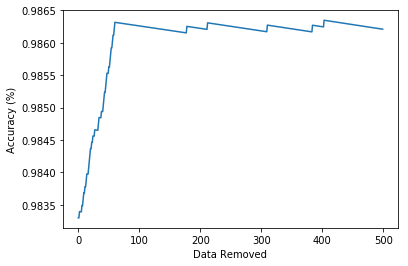

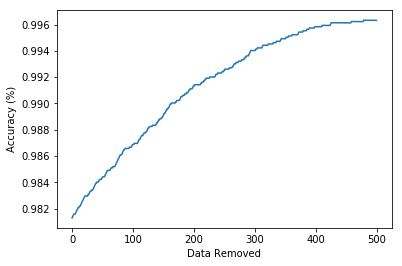

In [0]:
sgd_net = torch.load("SGD_weights.pt")
dropout_net = torch.load("dropout_weights.pt")
dropout_net.train()

def expected_entropy(net, input_data, num_samples=100):
    with torch.no_grad():
        outputs = torch.empty(num_samples, input_data.size()[0], 10)
        for i in range(num_samples):
            outputs[i] = net.forward(input_data)
            outputs[i] = torch.exp(outputs[i])+1e-45
        outputs = outputs.mean(0)
        MC = torch.sum(outputs*torch.log(outputs), dim = 1)
    #MC = MC.mean(0)
    return MC

def test(net):
    test_accu_lst = []
    pred_class = net(test_X).data.cpu().numpy().argmax(axis=1)
    true_class = test_Y.data.cpu().numpy().ravel()
    test_accu = (pred_class == true_class).sum()
    entropy = expected_entropy(net, test_X, 100)
    entropy = entropy.data.cpu().numpy().ravel()
    equ = pred_class == true_class
    entropy_pair = sorted(list(zip(entropy, equ)), key=lambda tup: tup[0])
    cur_test_size = test_size
    for i in range(500):
      cur_test_size-=1
      if(entropy_pair[i][1]):
        test_accu -= 1
      test_accu_lst.append(test_accu/cur_test_size)
    plt.plot(test_accu_lst, label='Train')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Data Removed')
    plt.show()

test(sgd_net)
test(dropout_net)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

bayesian_parameters = list(net.parameters())
bayesian_parameters = np.concatenate([bayesian_parameters[i].data.cpu().numpy().reshape(-1,) for i in range(len(bayesian_parameters)) if i % 2 == 0])

sns.kdeplot(bayesian_parameters, shade=True, label="bayesian")

plt.legend()